<a href="https://colab.research.google.com/github/chenpenghao/FE5112/blob/main/FE5112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python Environment Setup

In [ ]:
#@title
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [ ]:
#@title
!pip install --target=$nb_path pandas

**Market:**

The market is complete and arbitrage free. The risk free interest rate is 8%. The price of a non-dividend-paying stock $S_t$ at time t is governed by the fllowing SDE under the risk neutral probability measure $\mathbb{Q}$ :
\begin{align}
d{S_t} &= 0.08 \times S_t{dt} + \sigma(S_t) \times S_t{dW_t}\\
S_0 &= 100
\end{align}

where $W_t$ is a Brownian motion under $\mathbb{Q}$ and $\sigma(\cdot)$ is a function given as follows:
\begin{equation}
  \sigma(x) = \begin{cases}
    0.25 + 0.02 \times ( 1.0 - \frac{x}{S_0}), \text{ for } x \leq 100;\\
    max(0.001, 0.25-0.01 \times (\frac{x}{S_0} - 1)), \text{ for } x > 100
  \end{cases}
\end{equation}





Array of Option Payouts for all Scenarios for day 730 
 [56.48939091  0.          0.          2.55767291  0.        ]
Computed optionPrice =  10.063317736735627


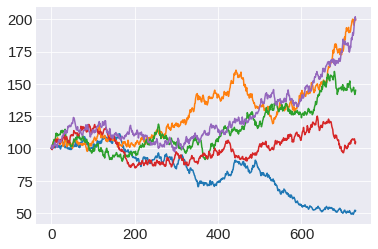

In [ ]:
# market specific
import math
import random
import numpy as np
from numpy import array

T = 2         # duration in years
L = 730       # number of time intervals
M = 5       # number of asset paths
rf = 0.08     # risk free rate
S0 = 100.0    # Beginning stock price
dt = T/L      # time discretization
dayEx = 730   # day of exercise within the tenor

discf = math.exp(-rf*dt) 

def _sig(x, s0):
  if x <= 100:
    return 0.25 + 0.02 * (1.0 - x/s0)
  else:
    return max(0.001, 0.25-0.01*(x/s0 - 1))

def sig(x):
  return _sig(x, S0)

def generatePaths(L, M, dt, rf, S0):
  # S has L+1 columns and M rows
  S = [[S0 for i in range(L+1)] for j in range(M)] 

  for i in range(len(S)):
    for j in range(1, len(S[i])):
      dS = rf * S[i][j-1] * dt + sig(S[i][j-1])*S[i][j-1]*math.sqrt(dt)*random.gauss(0,1)
      S[i][j] = S[i][j-1] + dS

  return array(S)

S = generatePaths(L, M, dt, rf, S0)


#print(S)
payoutOption = AAOptionPayout(S, dayEx, K)
print("Array of Option Payouts for all Scenarios for day", dayEx, "\n", payoutOption)
optionPrice = findExpectation(payoutOption) * math.exp(-rf*dayEx*dt)
print("Computed optionPrice = ", optionPrice)

## TODO
### Perform the LSMC method to regress the option activation prices from day- 
### -730 to 366 to find the stopping time and payouts 




## Testing code
#testMean = findAvg(S, dayEx)
#print(testMean)
#payoutOption = AAOptionPayout(S, dayEx, 108)

#sPrices = S[:, dayEx-60:dayEx]
#sMeans = np.mean(sPrices, axis=1)
#print(sMeans)
#payout = np.maximum(108-sMeans, 0)
#print(payout)



# Section to plot the price states 
import matplotlib.pyplot as plt
for i in S:
  plt.plot(i)




In [ ]:
import pandas as pd
df = pd.DataFrame(data=S).T

ave = df.mean(axis=1)
df.index

RangeIndex(start=0, stop=731, step=1)

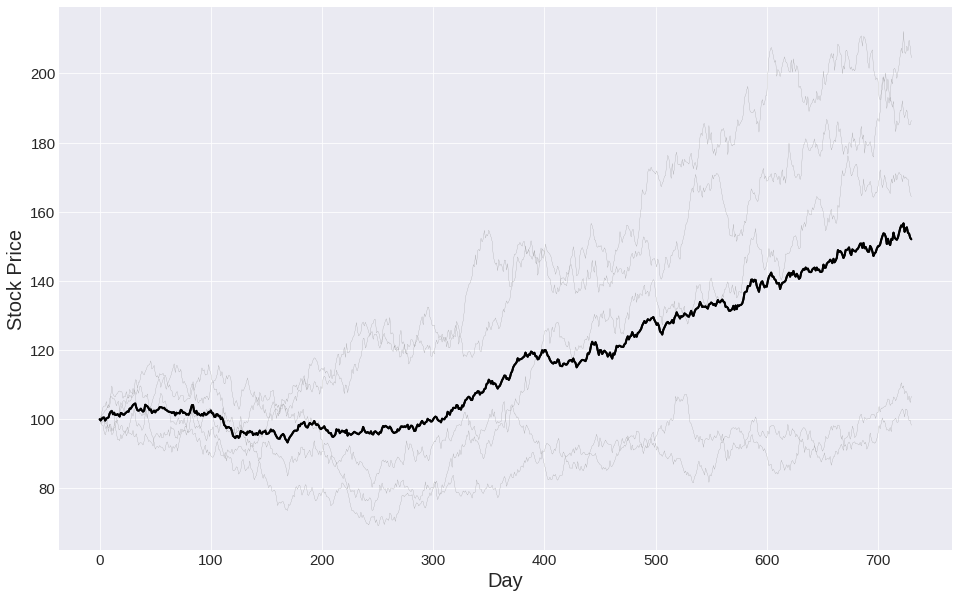

In [ ]:
## Visualisations

plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('binary')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Day', fontsize=20)
plt.ylabel('Stock Price', fontsize=20)

# 1st representation for plotting
plt.plot(df,color=palette(120), lw=0.2)
plt.plot(ave,color=palette(2000), lw=2)

# 2nd representation for plotting
#for column in df.columns:
#  plt.plot(df[column],color=palette(120), lw=0.2)
#  plt.fill_between(df[column], ave, color='lightgrey', alpha=0.5)

plt.plot(ave,color=palette(2000), lw=2)
plt.show()

**Option to Price**

It is a one-year-non-exercise American Asian put option with the strike price $K=108$ and the maturity $T=2$(years). The potion is not exercisable in the first year. The option is exercisable once and only once in the second year. If the option is exercised on day $n, 366 \leq n \leq 730$, the option buyer will receive a payout of $(K - A_n)^{+}$ where
$$A_n = \frac{1}{60}\sum^{-1}_{i=-60}S_{\frac{n+i}{365}}$$

In [ ]:
# Asset related

K = 108

# Function computes the expected value of the option price based on the payouts
def findExpectation(An_sim):
  ''' Placeholder for finding the expectation using the simulated price paths '''
  return np.mean(An_sim)

# Function computes the average of stock price in past 60 days from day of Exercise
# Returns the 60 day average array for all asset paths 
def findAvg(S, dayEx):
  ''' Find the averages  '''
  if dayEx <= 365:
    raise Exception('Option cannot be exercised before the second year.')
  else:
    sPrices = S[:, dayEx-60:dayEx]
    sMeans = np.mean(sPrices, axis=1)
    return sMeans

def AAOptionPayout (stockPrices, dayEx, K):
  try:
    An = findAvg(stockPrices, dayEx) 
    payout = np.maximum(108-An, 0)
    return payout
  except Exception as e:
    print(e)




#test
#print(sig(50))
#findAvg(np.array([[1] * 730] * 4), 368)
#AAOptionPayout(S, dayEx, 108)

In [ ]:
#@title Default title text
# Code for the Monte Carlo simulation

K = 108
fit_deg = 2

def LSMC_plain(S, K, lookback_periods = 60, fit_deg=2):
  ''' Code draft for least-squared Monte Carlo simulation without any variance reduction '''
  # init exercise_info: key is the path number, value is (<day on which exercise>, <intrinsic value at exercise>)
  # all initialize to (maxDay+1, -1)
  L = len(S[0]) - 1
  M = len(S) 
  defaultDicValue = (L+1, -1)
  exercise_info = {}

  def intrinsic_val_func(S, dayi, pathNum):
    S_past60 = S[ pathNum, dayi-lookback_periods : dayi ]
    An = sum(S_past60) / 60
    return max(K-An, 0)

  for i in range(M):
    exercise_info[i] = defaultDicValue

  for i in range(L-1, 365, -1):   # starting with the i-1^th column
    S_i_col = S[:, i].tolist()
    payoff_col = [intrinsic_val_func(S, i, j) for j in range(M)]
    in_the_money_path_numbers = [i for i in range(len(S_i_col)) if payoff_col[i] > 0]

    if not in_the_money_path_numbers:  # All paths not in the money on the day, skip
      continue

    xs = [S_i_col[j] for j in in_the_money_path_numbers]   # the S_i on paths that are in the money
    ys= [intrinsic_val_func(S, i+1, j) for j in in_the_money_path_numbers]  # the discounted future day intrinsic value for those paths that are in the money
    coeff = np.polyfit(xs, ys, fit_deg) # return the coeff (a,b,c) for ax^2 + bx + c

    a,b,c = coeff
    pi_func = lambda x: a*x*x + b*x + c
    piSi_col = [pi_func(x) for x in xs] # map to p_i(S_i) value for only the chosen S_i
    intrinsic_col = [payoff_col[j] for j in in_the_money_path_numbers]
    for pathNum, val, piSi in zip(in_the_money_path_numbers, intrinsic_col, piSi_col):
      if val > piSi:  # max(K-S_i) > p_i(S_i)
        exercise_info[pathNum] = (i, val)   # if on an earlier day the exercise criteria satisfies, it should exercise earlier, thus overwrite the previous day
                                            # TODO: there is room for discussion here - if for a path on multiple days it can exercise, which day do we take? 
                                            # KJ: I suppose the option should be exercised on an earlier day. We should consider ownership of the option. 
                                            #     Decision is made on a chronological order so there may be option exercise when K-S is more than future value  

  print(exercise_info)

  # For those among the exercise_info dict that are still with the default values, need to check if it can exercise on the final period (day L).
  for path in exercise_info:
    if exercise_info[path] == defaultDicValue:
      if intrinsic_val_func(S, L, path) > 0:
        exercise_info[path] = (L, intrinsic_val_func(S, L, path))
      else:
        exercise_info[path] = (L, 0)

  print(exercise_info)
  # Finally we (1) discount back the intrinsic value (2) take average
  discountedValues = []
  for path in exercise_info:
    exercise_day, intrinsic_val = exercise_info[path]
    discountedValues.append(intrinsic_val * math.exp(-rf * exercise_day * (2/L)))

  return sum(discountedValues) / len(discountedValues)

finalValue = LSMC_plain(S, K)
print(finalValue)

In [ ]:
s = [LSMC_plain(generatePaths(L, M, dt, rf, S0), K) for _ in range(10)]


Found this from an online source: https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/2.3%20American%20Options.ipynb

# Valuation by LS Method

N = 4          # number of time steps

r = 0.06       # interest rate

K = 1.1        # strike 

T = 3          # Maturity

dt = T/(N-1)          # time interval

df = np.exp(-r * dt)  # discount factor per time interval

H = np.maximum(K - S, 0)           # intrinsic values for put option

V = np.zeros_like(H)               # value matrix

V[:,-1] = H[:,-1]

for t in range(N-2, 0, -1):

    good_paths = H[:,t] > 0        # paths where the intrinsic value is positive 
                                   # the regression is performed only on these paths 
    
    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, 2)    # polynomial regression
    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  
    
    exercise = np.zeros( len(good_paths), dtype=bool)    # initialize
    exercise[good_paths] = H[good_paths,t] > C           # paths where it is optimal to exercise
    
    V[exercise,t] = H[exercise,t]                        # set V equal to H where it is optimal to exercise 
    V[exercise,t+1:] = 0                                 # set future cash flows, for that path, equal to zero  
    discount_path = (V[:,t] == 0)                        # paths where we didn't exercise 
    V[discount_path,t] = V[discount_path,t+1] * df       # set V[t] in continuation region
    
V0 = np.mean(V[:,1]) * df  # discounted expectation of V[t=1]

print("Example price= ", V0)

In [ ]:
def print_mean_var(s):
  mean = sum(s)/len(s)
  var = sum([(i - mean)**2 for i in s])/(len(s)-1)
  print(mean, var)

print(s)
print_mean_var(s)

[13.555214918149801, 6.896765592660126, 6.9159017070278495, 5.916184440081845, 7.264237171215997, 7.429252001903907, 3.8159579454766446, 10.10367302672553, 17.436976821153046, 14.86436066308787]
9.41985242874826 19.60111259084477


In [ ]:
# Variance Reduction

## Antithetic method
stockPath = [[S0 for j in range(L+1)] for k in range(M)] 
stockAntiPath = [[S0 for j in range(L+1)] for k in range(M)]

def generateRand():
  randArray = [[random.gauss(0,1) for j in range(L+1)] for k in range(M)] 
  return randArray

def generatePathsVar(L, M, dt, rf, S0):

  for i in range(len(stockPath)):
    for j in range(1, len(stockPath[i])):
      rand = random.gauss(0,1)
      dS = rf * stockPath[i][j-1] * dt + sig(stockPath[i][j-1])*stockPath[i][j-1]*math.sqrt(dt)*rand
      dS_anti = rf * stockPath[i][j-1] * dt - sig(stockPath[i][j-1])*stockPath[i][j-1]*math.sqrt(dt)*rand
      stockPath[i][j] = stockPath[i][j-1] + dS
      stockAntiPath[i][j] = stockAntiPath[i][j-1] + dS_anti

    #  dS_anti = rf * S2[i][j-1][1] * dt - sig(S2[i][j-1][1])*S2[i][j-1][1]*math.sqrt(dt)*rand

## Testing Section
generatePathsVar(L, M, dt, rf, S0)
#print(array(stockPath))
#print(array(stockAntiPath))
optionValue = LSMC_plain(array(stockPath), K)
aAntiOptionValue = LSMC_plain(array(stockAntiPath), K)
aOptionVal = (aOptionValue + aAntiOptionValue)/2 
print("Option Value Without Variance Reduction:", aOptionValue)
print("Option Value with Variance Reduction:", optionVal)
import statistics as stat
varReduction = 1 - stat.variance(aOptionVal)/stat.variance(optionValue)
print("Variance Reduction Rate:", varReduction)


## Visualisations
plt.plot(stockPath[1])
plt.plot(stockAntiPath[1])

#for j in stockPath:
#  plt.plot(j)
#for j in stockAntiPath:
#  plt.plot(j)



{0: (384, 29.942452281616454), 1: (402, 41.221896042577995), 2: (366, 37.05133958968642), 3: (366, 12.549864534042896), 4: (402, 18.84082335500844)}
{0: (384, 29.942452281616454), 1: (402, 41.221896042577995), 2: (366, 37.05133958968642), 3: (366, 12.549864534042896), 4: (402, 18.84082335500844)}
{0: (731, -1), 1: (731, -1), 2: (731, -1), 3: (731, -1), 4: (731, -1)}
{0: (730, 0), 1: (730, 0), 2: (730, 0), 3: (730, 5.116765575673668), 4: (730, 0)}
Option Value Without Variance Reduction: 12.932708883554238
Option Value with Variance Reduction: 15.13277448650991


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly cond

TypeError: ignored

In [ ]:
## Control Variate Method



In [ ]:
## Importance Sampling
import scipy.stats as stats
import numpy as np

%precision 10
h_true =1 - stats.norm().cdf(5)

n = 10000
y = stats.norm().rvs(n)
h_mc = 1.0/n * np.sum(y > 5)
# estimate and relative error
h_mc, np.abs(h_mc - h_true)/h_true

y = stats.expon(loc=5).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y)) #importance sampling
# estimate and relative error
h_is, np.abs(h_is- h_true)/h_true

(0.0000002885, 0.0065004183)